# Automatic Kernel Selection in GPyTorch

This notebook demonstrates how to automatically select the best Gaussian Process (GP) kernel from a set of candidate kernels by comparing their marginal likelihoods. We:

- Generate synthetic 1D data.
- Define an exact GP model that accepts a kernel type.
- Train GP models with candidate kernels (RBF, Matern, Periodic) for a few iterations.
- Select the kernel with the lowest negative log marginal likelihood.
- Retrain the model with the best kernel and make predictions with uncertainty quantification.

Let's get started!

In [1]:
import math
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Generating Synthetic Data

We generate synthetic 1D data from a noisy sine function. This data will serve as the training data for our GP regression model.

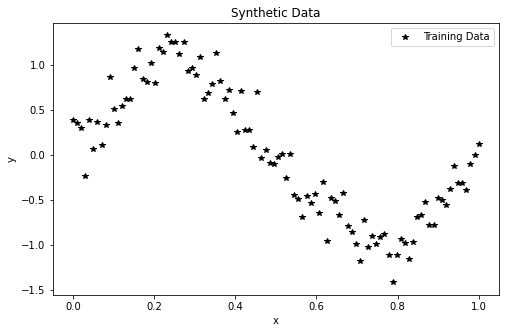

In [2]:
# Generate training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a test grid
test_x = torch.linspace(0, 1, 200)

# Plot the training data
plt.figure(figsize=(8, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data')
plt.legend()
plt.show()

## 2. Defining the GP Model

We define an exact GP model by subclassing `gpytorch.models.ExactGP`. The model accepts a `kernel_type` parameter so that we can swap between different kernels. If an unrecognized kernel is specified, we default to the RBF kernel.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_type="RBF"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        # Mean module
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Choose kernel type
        if kernel_type == "RBF":
            covar_module = gpytorch.kernels.RBFKernel()
        elif kernel_type == "Matern":
            covar_module = gpytorch.kernels.MaternKernel(nu=2.5)
        elif kernel_type == "Periodic":
            covar_module = gpytorch.kernels.PeriodicKernel()
        else:
            print("Kernel type not recognized. Defaulting to RBF.")
            covar_module = gpytorch.kernels.RBFKernel()
        
        # Wrap the kernel in a ScaleKernel
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 3. Automatic Kernel Selection

We consider a set of candidate kernels and train a GP model for each candidate for a small number of iterations. Then, we select the kernel that achieves the lowest negative log marginal likelihood (i.e., the best training loss).

In [4]:
candidate_kernels = ["RBF", "Matern", "Periodic"]

results = {}

training_iterations = 50  # iterations for candidate evaluation

for kernel in candidate_kernels:
    print(f"Training with kernel: {kernel}")
    
    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel_type=kernel)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    final_loss = loss.item()
    results[kernel] = final_loss
    print(f"Final negative log marginal likelihood for {kernel}: {final_loss:.3f}\n")

# Choose the best kernel (lowest loss)
best_kernel = min(results, key=results.get)
print("Best kernel based on negative log marginal likelihood:", best_kernel)

Training with kernel: RBF
Final negative log marginal likelihood for RBF: -0.087

Training with kernel: Matern
Final negative log marginal likelihood for Matern: -0.081

Training with kernel: Periodic
Final negative log marginal likelihood for Periodic: -0.087

Best kernel based on negative log marginal likelihood: RBF


## 4. Retraining with the Automatically Selected Kernel

Now we retrain a GP model using the best kernel identified above for a larger number of iterations.

Iteration 10/100 - Loss: 0.548
Iteration 20/100 - Loss: 0.194
Iteration 30/100 - Loss: -0.057
Iteration 40/100 - Loss: -0.085
Iteration 50/100 - Loss: -0.087
Iteration 60/100 - Loss: -0.098
Iteration 70/100 - Loss: -0.097
Iteration 80/100 - Loss: -0.098
Iteration 90/100 - Loss: -0.098
Iteration 100/100 - Loss: -0.098


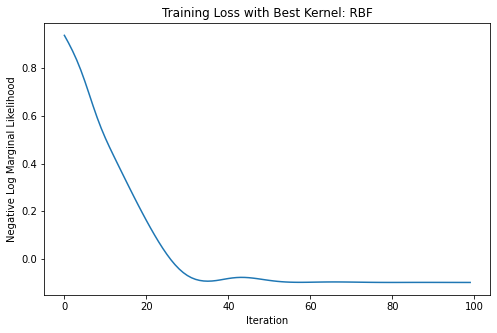

In [5]:
# Retrain with the best kernel
likelihood_best = gpytorch.likelihoods.GaussianLikelihood()
model_best = ExactGPModel(train_x, train_y, likelihood_best, kernel_type=best_kernel)

model_best.train()
likelihood_best.train()

optimizer_best = torch.optim.Adam(model_best.parameters(), lr=0.1)
mll_best = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_best, model_best)

training_iterations_full = 100
loss_history_best = []

for i in range(training_iterations_full):
    optimizer_best.zero_grad()
    output = model_best(train_x)
    loss = -mll_best(output, train_y)
    loss.backward()
    optimizer_best.step()
    loss_history_best.append(loss.item())
    if (i+1) % 10 == 0:
        print(f"Iteration {i+1}/{training_iterations_full} - Loss: {loss.item():.3f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history_best)
plt.xlabel("Iteration")
plt.ylabel("Negative Log Marginal Likelihood")
plt.title(f"Training Loss with Best Kernel: {best_kernel}")
plt.show()

## 5. Making Predictions

Finally, we make predictions on the test grid using the retrained model with the automatically selected kernel. We then plot the predictive mean along with 95% confidence intervals.

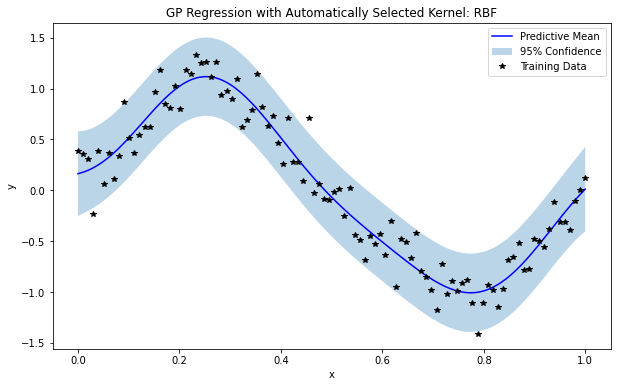

In [6]:
model_best.eval()
likelihood_best.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood_best(model_best(test_x))

# Extract predictive mean and confidence intervals
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()
lower = lower.numpy()
upper = upper.numpy()

plt.figure(figsize=(10, 6))
plt.plot(test_x.numpy(), mean, 'b', label='Predictive Mean')
plt.fill_between(test_x.numpy(), lower, upper, alpha=0.3, label='95% Confidence')
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GP Regression with Automatically Selected Kernel: {best_kernel}')
plt.legend()
plt.show()

## Conclusion

In this tutorial, we demonstrated how to automatically select the best GP kernel based on the marginal likelihood. We trained candidate GP models with different kernels, selected the kernel with the lowest negative log marginal likelihood, and retrained a final model using that kernel to make predictions with uncertainty quantification.

Feel free to extend this approach by considering additional candidate kernels or employing more advanced model selection techniques.